# <center> Sending and receiving a pulse demonstration

### <center> In this demo you will send and receive a pulse in loopback to demonstrate control over the QICK. 

By modifying the <code> config </code> Python dictionary in the below notebook cell, you can change several variables:
* The pulse length <code> length </code> in FPGA clock ticks (1 clock tick = 2.6 ns).
* The readout buffer length <code> readout_length </code> in FPGA clock ticks.
* The pulse envelope shape <code> pulse_style </code> (either <code> const </code> or <code> flat_top </code> or <code> arb </code>)
* The pulse amplitude <code> pulse_gain </code> in DAC units.
* The pulse frequency <code> pulse_freq </code> in MHz.
* The readout "time of flight" <code> adc_trig_offset </code> in FPGA clock ticks.
* The number of times you average the read <code> soft_avgs </code>

In [184]:
# Import the QICK drivers and auxiliary libraries
from qick import *
from qick.helpers import gauss
import time
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [185]:
# Load bitstream with custom overlay
# soc = QickSoc()
# soc = QickSoc(bitfile="../q3diamond/q3diamond.bit", force_init_clks=True)
soc = QickSoc(bitfile="qick-amo.bit")
# soc = QickSoc(bitfile="q3diamond.bit",force_init_clks=True)
dac_locked = [soc.rf.dac_tiles[iTile].PLLLockStatus==2 for iTile in soc.dac_tiles]
adc_locked = [soc.rf.adc_tiles[iTile].PLLLockStatus==2 for iTile in soc.adc_tiles]
print(dac_locked, adc_locked)

# Since we're running locally on the QICK, we don't need a separate QickConfig object.
# If running remotely, you could generate a QickConfig from the QickSoc:
#     soccfg = QickConfig(soc.get_cfg())
# or save the config to file, and load it later:
#     with open("qick_config.json", "w") as f:
#         f.write(soc.dump_cfg())
#     soccfg = QickConfig("qick_config.json")
soccfg = soc
print(soccfg)


[True, True, True] [True]

QICK configuration:

	Board: ZCU216

	Global clocks (MHz): tProcessor 349.997, RF reference 245.760

	7 signal generator channels:
	0:	axis_sg_int4_v1 - tProc output 0, switch ch 0, maxlen 4096
		DAC tile 2, ch 0, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	1:	axis_sg_int4_v1 - tProc output 1, switch ch 1, maxlen 4096
		DAC tile 2, ch 1, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	2:	axis_sg_int4_v1 - tProc output 2, switch ch 2, maxlen 4096
		DAC tile 2, ch 2, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	3:	axis_sg_int4_v1 - tProc output 3, switch ch 3, maxlen 4096
		DAC tile 2, ch 3, 16-bit DDS, fabric=430.080 MHz, fs=1720.320 MHz
	4:	axis_signal_gen_v5 - tProc output 4, switch ch 4, maxlen 65536
		DAC tile 3, ch 0, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	5:	axis_signal_gen_v5 - tProc output 5, switch ch 5, maxlen 65536
		DAC tile 3, ch 1, 32-bit DDS, fabric=599.040 MHz, fs=9584.640 MHz
	6:	axis_signal_gen_v5 - tProc output 6, switch 

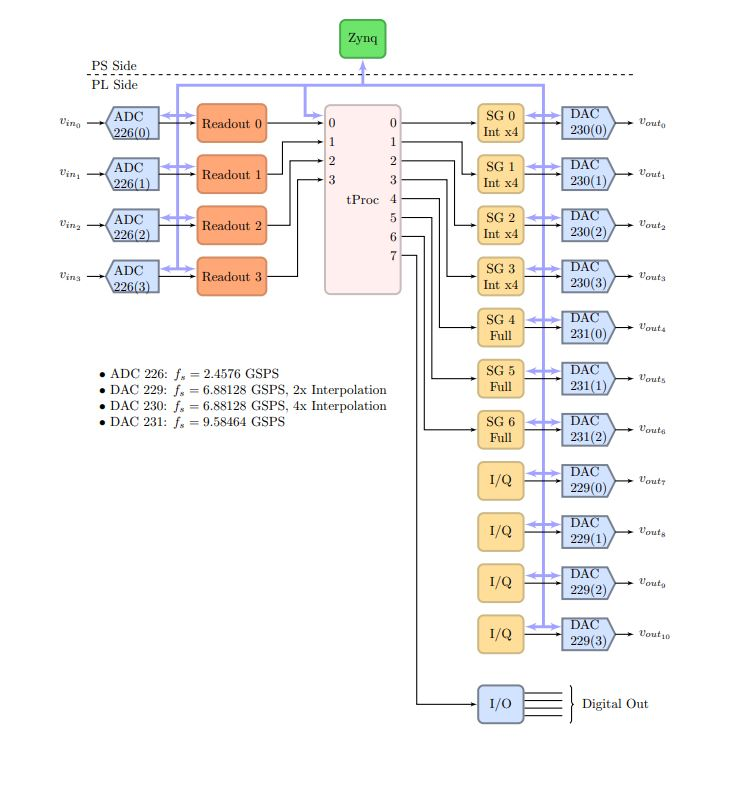

### Waveform signal generators (signal_gen, sg_int4)
In these demos you can set res_ch to any signal generator that supports waveforms - either a signal_gen or an sg_int4.
If you use an sg_int4, you could also set the mixer_freq to a nonzero value.

Note the following:
* signal_gen_v5 has known problems with phase (it is not consistent shot-to-shot), and the generator always exhibits stdysel="last" behavior (i.e. the last clock's worth of waveform repeats forever, giving you a DC offset plus some RF - probably not what you want, this is normally only visible with the "const" pulse style).
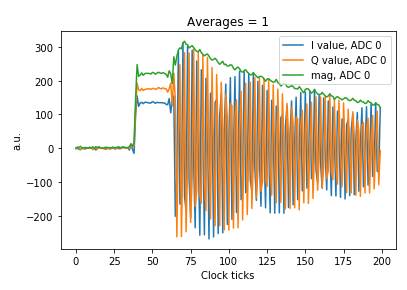
* Both signal_gen_v5 and sg_int4 seem to have glitches between flat_top pulse segments. With signal_gen_v5 these glitches are rare (1/100 shots?), and when this happens one segment has an entirely different phase from the next. With sg_int4 the glitches are always present, but only the samples at the segment boundaries are affected - maybe this is because the interpolation is rounding the envelopes off at the ends.

sg_int4:
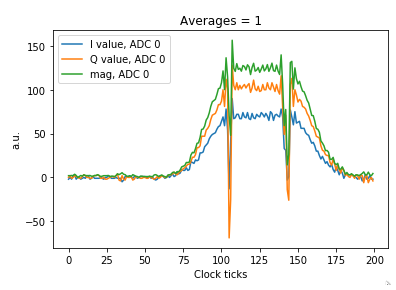

signal_gen_v5:
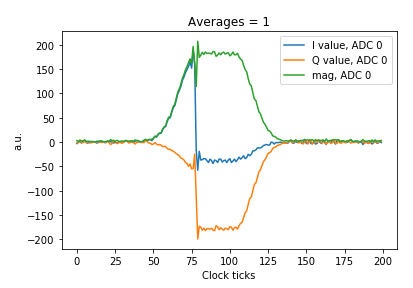


In [186]:
for gen in soc.gens:
    print(gen)
    if gen.HAS_MIXER:
        print(gen.get_mixer_freq())
    if hasattr(gen, 'get_freq'):
        print([gen.get_freq(i) for i in range(4)])

500.0000000000094
500.0000000000094
500.0000000000094
500.0000000000094


In [187]:
class LoopbackProgram(AveragerProgram):
    def __init__(self,soccfg,cfg):
        super().__init__(soccfg,cfg)

    def initialize(self):
        cfg=self.cfg   
        res_ch = cfg["res_ch"]
#         r_freq=self.sreg(cfg["res_ch"], "freq")   #Get frequency register for res_ch
        self.declare_gen(ch=res_ch, nqz=1, mixer_freq=cfg["mixer_freq"], ro_ch=cfg["ro_chs"][0])

        #configure the readout lengths and downconversion frequencies
        for ro_ch in cfg["ro_chs"]:
            self.declare_readout(ch=ro_ch, freq=cfg["demod_freq"], length=cfg["readout_length"], gen_ch=cfg["res_ch"])
        
        style=self.cfg["pulse_style"]
        freq=self.freq2reg(cfg["pulse_freq"],gen_ch=res_ch, ro_ch=cfg["ro_chs"][0])  # convert frequency to dac frequency (ensuring it is an available adc frequency)
        #print("generator freq:", self.reg2freq(freq, gen_ch=res_ch))
        
        if style in ["flat_top","arb"]:
            sigma = cfg["sigma"]
            nsigma = 5
            samples_per_clock = self.soccfg['gens'][res_ch]['samps_per_clk']
            idata = helpers.gauss(mu=sigma*samples_per_clock*nsigma/2,
                                  si=sigma*samples_per_clock,
                                  length=sigma*samples_per_clock*nsigma,
                                  maxv=np.iinfo(np.int16).max-1)
            self.add_pulse(ch=res_ch, name="measure", idata=idata) 
            
        if style == "const":
            self.set_pulse_registers(ch=res_ch, style=style, freq=freq, phase=0, gain=cfg["pulse_gain"], length=cfg["length"])
        elif style == "flat_top":
            self.set_pulse_registers(ch=res_ch, style=style, freq=freq, phase=0, gain=cfg["pulse_gain"], waveform="measure", length=cfg["length"])
        elif style == "arb":
            self.set_pulse_registers(ch=res_ch, style=style, freq=freq, phase=0, gain=cfg["pulse_gain"], waveform="measure")
        
        self.synci(200)  # give processor some time to configure pulses
    
    def body(self):
        self.synci(200) # give processor time to get ahead of the pulses
        self.trigger(adcs=self.ro_chs,pins=[0],adc_trig_offset=self.cfg["adc_trig_offset"])  # trigger the adc acquisition
        self.pulse(ch=self.cfg["res_ch"]) # play readout pulse
        # control should wait until the readout is over
        self.waiti(0, self.cfg["adc_trig_offset"]+self.cfg["readout_length"]) 
        self.sync_all(self.us2cycles(self.cfg["relax_delay"]))  # sync all channels


### Send/receive a pulse with <code> pulse_style </code> = <code> arb </code>

In [188]:
config={"res_ch":0, # --Fixed
        "mixer_freq":0.0, # MHz
        "ro_chs":[2], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1, # --Fixed
        "res_phase":0, # --Fixed
        "pulse_style": "arb", # --Fixed
        
        "sigma": 30, # [Clock ticks]
        # Try varying sigma from 10-50 clock ticks
        
        "readout_length":200, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":5000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 100, # [MHz]
        "demod_freq": 100, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":10
        # Try varying soft_avgs from 1 to 200 averages

       }

prog =LoopbackProgram(soccfg, config)
soc.reset_gens() # clear any DC or periodic values on generators
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)
# print(prog)

  0%|          | 0/10 [00:00<?, ?it/s]

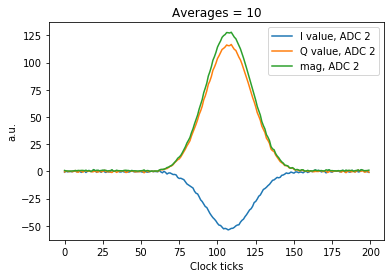

In [189]:
# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()
# plt.savefig("images/Send_recieve_pulse_const.pdf", dpi=350)

### Demodulate at a different frequency (e.g. DC)

In [190]:
config={"res_ch":0, # --Fixed
        "mixer_freq":0.0, # MHz
        "ro_chs":[2], # --Fixed
        "reps":1, # --Fixed
        "relax_delay":1, # --Fixed
        "res_phase":0, # --Fixed
        "pulse_style": "arb", # --Fixed
        
        "sigma": 100, # [Clock ticks]
        # Try varying sigma from 10-50 clock ticks
        
        "readout_length":1000, # [Clock ticks]
        # Try varying readout_length from 50-1000 clock ticks

        "pulse_gain":5000, # [DAC units]
        # Try varying pulse_gain from 500 to 30000 DAC units

        "pulse_freq": 10, # [MHz]
        "demod_freq": 0, # [MHz]
        # In this program the signal is up and downconverted digitally so you won't see any frequency
        # components in the I/Q traces below. But since the signal gain depends on frequency, 
        # if you lower pulse_freq you will see an increased gain.

        "adc_trig_offset": 100, # [Clock ticks]
        # Try varying adc_trig_offset from 100 to 220 clock ticks

        "soft_avgs":1
        # Try varying soft_avgs from 1 to 200 averages

       }

prog =LoopbackProgram(soccfg, config)
soc.reset_gens() # clear any DC or periodic values on generators
iq_list = prog.acquire_decimated(soc, load_pulses=True, progress=True, debug=False)
# print(prog)

  0%|          | 0/1 [00:00<?, ?it/s]

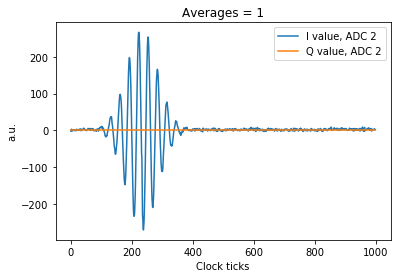

In [191]:
# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value, ADC %d"%(config['ro_chs'][ii]))
    plt.plot(iq[1], label="Q value, ADC %d"%(config['ro_chs'][ii]))
    #plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag, ADC %d"%(config['ro_chs'][ii]))
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()
# plt.savefig("images/Send_recieve_pulse_const.pdf", dpi=350)

peaks (MHz): [-9.830399999999992, 0.0, 9.830400000000008]


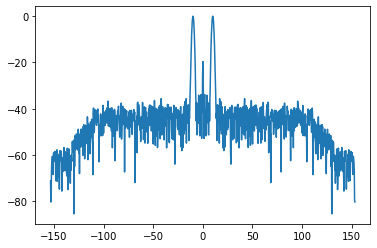

In [192]:
import scipy as sp
from scipy import fft, ifft, fftpack

#####################
### Plot spectrum ###
#####################
ch =2 # ADC sample rate
readout = soc.readouts[ch]
fs = soc.adcs[readout.adc]['fs']/8
#print(fs)
x = iq[0] + 1j*iq[1]
w = sp.hanning(len(x))
xw = x*w
Y = sp.fftpack.fftshift(sp.fft(xw))
F = (np.arange(len(Y))/len(Y)-0.5)*fs
plt.plot(F,20*np.log10(abs(Y)/np.max(abs(Y))))

from scipy.signal import find_peaks
peaks, _ = find_peaks(20*np.log10(abs(Y)/np.max(abs(Y))), height=-20)
print("peaks (MHz):", [F[x] for x in peaks])

### Change the constant I/Q channel parameters

In [198]:
#########################
### Always On Outputs ###
#########################
# A complex IQ constant is connected to these DACs.
# The amplitude of the output wave can be controlled by this constant.
# The frequency is controlled with the internal NCO of the DAC.
# NCO's frequency and Nyquist Zone are controlled with the mixer object.
#
# DACs are 0,1,2,3, tile 229.
# Sampling frequency is the same than Tile 230.

# Channel, gain, frequency and nyquist zone.
ch = 2
f = 1234
nq = 1
i=1
q=0

iq = soc.iqs[ch]
soc.set_iq(ch,f,i,q)
soc.set_nyquist(ch,nq)

print("Setting IQ %d:" %(ch))
print("-> DAC sampling frequency: %f" %(iq.fs))
print("-> DAC output frequency: %f" %(f))
print("-> DAC nyquist zone: %d" %(nq))

###  Verify this on the scope!

Setting IQ 2:
-> DAC sampling frequency: 6881.280000
-> DAC output frequency: 1234.000000
-> DAC nyquist zone: 1


### Demonstration of the external trigger (see Qick_AMO_Demo_ExtTrig)